# Binary Classification to determine whether engine will fail in given period

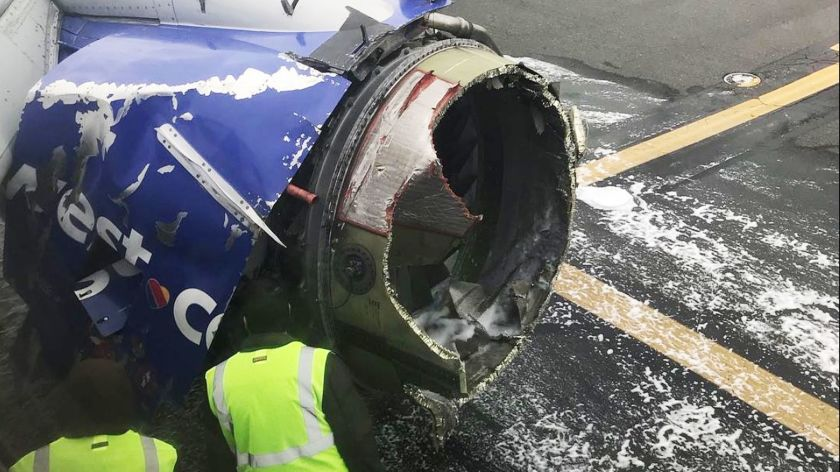

#Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier

### Load Data:

In [2]:
# load training data prepared previously
df_train = pd.read_csv('train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
# load test data prepared previously
df_test = pd.read_csv('test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


Create training and test data labels series.

Create features sets required to subset the original dataframes into original features and original + extracted features

In [4]:
# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_extr = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

y_train = df_train['label_bnc']
y_test = df_test['label_bnc']



### Binary Classifcation:

Let us add some helper fuctions

In [5]:
#@title Binary Classifier Function
def bin_classify(model, clf, features, params=None, score=None):
    X_train = df_train[features]

    X_test = df_test[features] 
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions
    

In [6]:
#@title Binary Classifier Metric Function
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True): 
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh


Using the above functions let us model and evaluate some binary classification algorithms

#Comparison for dataset with and without feature exraction

__In model names:__  

__B__ stands for applying the model on the original features set, __Before feature extraction  
__A__ stands for applying the model on the original + extracted features set, __After feature extraction  

# Logistic Regression

Before Feature Extraction:

C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Best Parameters:
 LogisticRegression(C=10, random_state=123)
-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.94      0.68      0.79        25

    accuracy                           0.91       100
   macro avg       0.92      0.83      0.87       100
weighted avg       0.91      0.91      0.90       100


Metrics:
           Logistic Regression B
Accuracy                0.910000
Precision               0.944444
Recall                  0.680000
F1 Score                0.790698
ROC AUC                 0.982933

ROC Thresholds:

       Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   1.997330e+00   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1   9.973299e-01   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
2   6.781922e-0

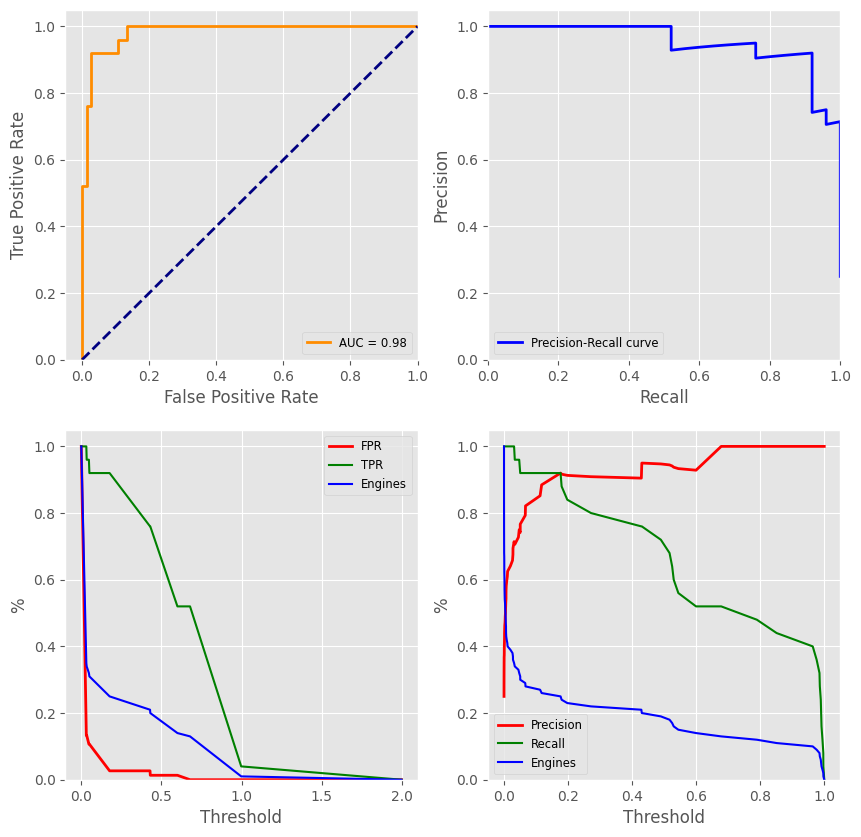

In [7]:
model = 'Logistic Regression B'
clf_lgrb = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgrb, pred_lgrb = bin_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, roc_lgrb, prc_lgrb = bin_class_metrics(model, y_test, pred_lgrb.y_pred, pred_lgrb.y_score, print_out=True, plot_out=True)

Engines in the above charts represent the queue or number of engines to be maintain per period, i.e. maintenance capacity.

After Feature Extraction

C:\Users\harsh\.conda\envs\h\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Best Parameters:
 LogisticRegression(C=10, random_state=123)
-----------------------------------------------------------
Logistic Regression A 

Confusion Matrix:
[[75  0]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        75
           1       1.00      0.68      0.81        25

    accuracy                           0.92       100
   macro avg       0.95      0.84      0.88       100
weighted avg       0.93      0.92      0.91       100


Metrics:
           Logistic Regression A
Accuracy                0.920000
Precision               1.000000
Recall                  0.680000
F1 Score                0.809524
ROC AUC                 0.981867

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.994097   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    0.994097   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
2    0.619561  17   8  7

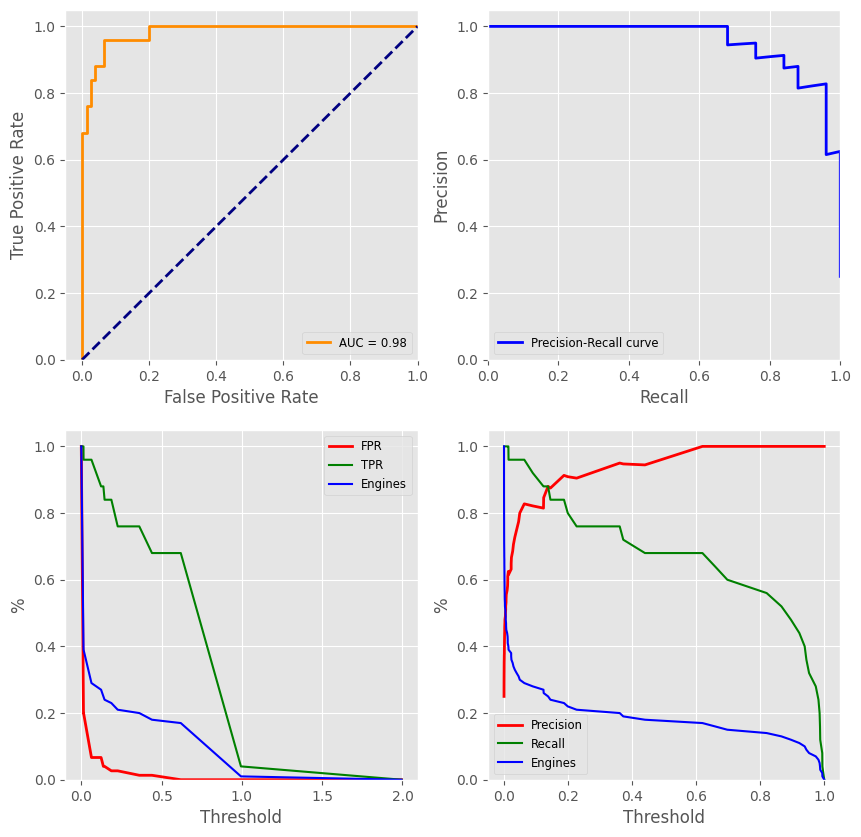

In [8]:
model = 'Logistic Regression A'
clf_lgra = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgra, pred_lgra = bin_classify(model, clf_lgra, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, roc_lgra, prc_lgra = bin_class_metrics(model, y_test, pred_lgra.y_pred, pred_lgra.y_score, print_out=True, plot_out=True)

In [9]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

,Logistic Regression B,Logistic Regression A
Accuracy,0.910000,0.920000
Precision,0.944444,1.000000
Recall,0.680000,0.680000
F1 Score,0.790698,0.809524
ROC AUC,0.982933,0.981867


# Decision Tree Classifier

Before Feature Extraction


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)
-----------------------------------------------------------
Decision Tree B 

Confusion Matrix:
[[74  1]
 [11 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.93      0.56      0.70        25

    accuracy                           0.88       100
   macro avg       0.90      0.77      0.81       100
weighted avg       0.89      0.88      0.87       100


Metrics:
           Decision Tree B
Accuracy          0.880000
Precision         0.933333
Recall            0.560000
F1 Score          0.700000
ROC AUC           0.945067

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    2.000000   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    1.000000   7  18  75   0  0.28  0.000000  1.000000  0.806452  0.07
2    0.938119   9  16  75   0  0.3

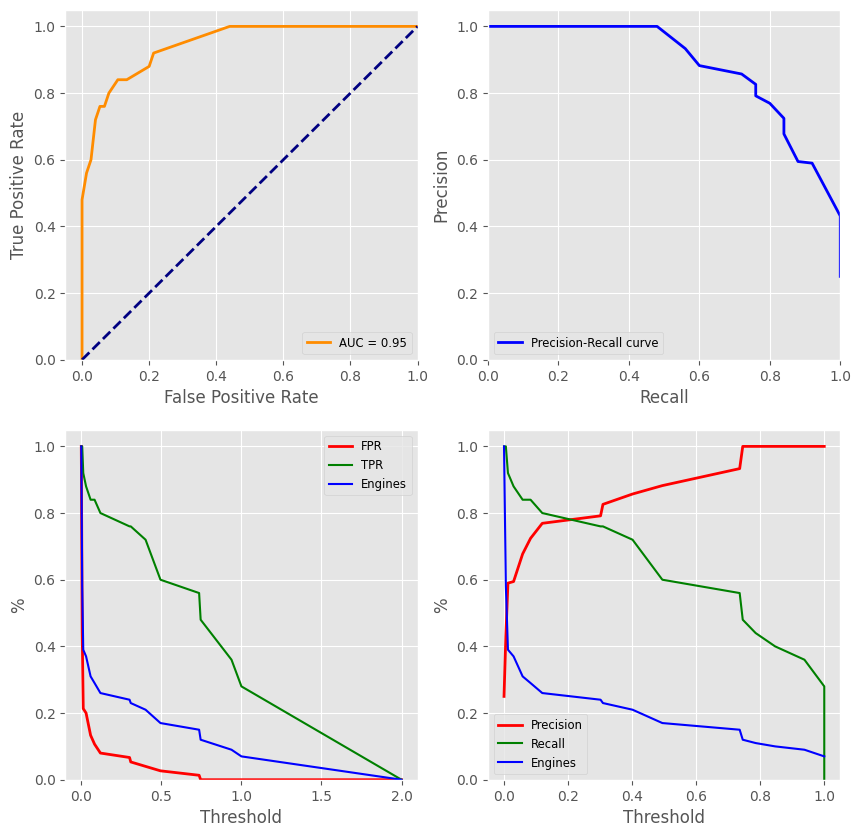

In [10]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [2, 3, 4, 5, 6], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtrb, pred_dtrb = bin_classify(model, clf_dtrb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_dtrb)

metrics_dtrb, roc_dtrb, prc_dtrb = bin_class_metrics(model, y_test, pred_dtrb.y_pred, pred_dtrb.y_score, print_out=True, plot_out=True)

After Feature Extraction


Best Parameters:
 DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)
-----------------------------------------------------------
Decision Tree A 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        75
           1       0.95      0.72      0.82        25

    accuracy                           0.92       100
   macro avg       0.93      0.85      0.88       100
weighted avg       0.92      0.92      0.92       100


Metrics:
           Decision Tree A
Accuracy          0.920000
Precision         0.947368
Recall            0.720000
F1 Score          0.818182
ROC AUC           0.962933

ROC Thresholds:

   Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   2.000000   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1   1.000000  10  15  75   0  0.40  0.000000  1.000000  0.833333  0.10
2   0.921053  11  14  75   0  0.44  0

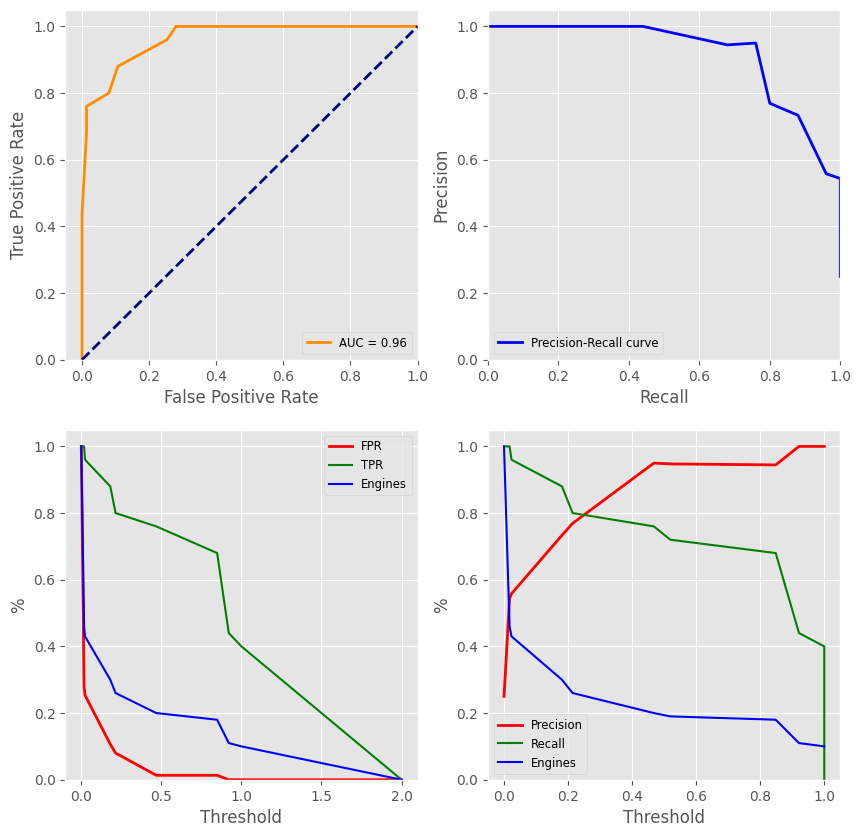

In [11]:
model = 'Decision Tree A'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [3, 4, 5, 6, 7], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtra, pred_dtra = bin_classify(model, clf_dtra, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_dtra)

metrics_dtra, roc_dtra, prc_dtra = bin_class_metrics(model, y_test, pred_dtra.y_pred, pred_dtra.y_score, print_out=True, plot_out=True)


In [12]:
metrics_dtr = pd.concat([metrics_dtrb, metrics_dtra], axis=1)
metrics_dtr

,Decision Tree B,Decision Tree A
Accuracy,0.880000,0.920000
Precision,0.933333,0.947368
Recall,0.560000,0.720000
F1 Score,0.700000,0.818182
ROC AUC,0.945067,0.962933


# Random Forest Classifier

Before Feature Extraction


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50,
                       random_state=123)
-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.94      0.68      0.79        25

    accuracy                           0.91       100
   macro avg       0.92      0.83      0.87       100
weighted avg       0.91      0.91      0.90       100


Metrics:
           Random Forest B
Accuracy          0.910000
Precision         0.944444
Recall            0.680000
F1 Score          0.790698
ROC AUC           0.980267

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.997997   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    0.997997   1  24  75   0  0.04  0.000000  1.000000  0.757576 

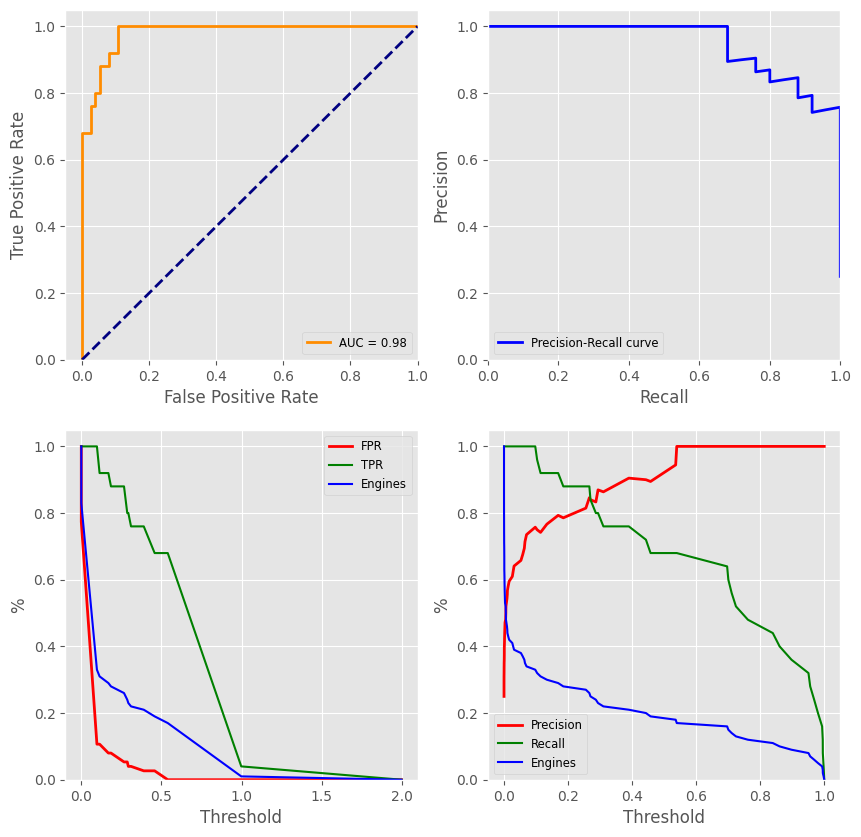

In [13]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfcb, pred_rfcb = bin_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, roc_rfcb, prc_rfcb = bin_class_metrics(model, y_test, pred_rfcb.y_pred, pred_rfcb.y_score, print_out=True, plot_out=True)

After Feature Extraction


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=50,
                       random_state=123)
-----------------------------------------------------------
Random Forest A 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.94      0.68      0.79        25

    accuracy                           0.91       100
   macro avg       0.92      0.83      0.87       100
weighted avg       0.91      0.91      0.90       100


Metrics:
           Random Forest A
Accuracy          0.910000
Precision         0.944444
Recall            0.680000
F1 Score          0.790698
ROC AUC           0.982400

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.999685   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1    0.999685   1  24  75   0  0.04  0.000000  1.000000  0.757576 

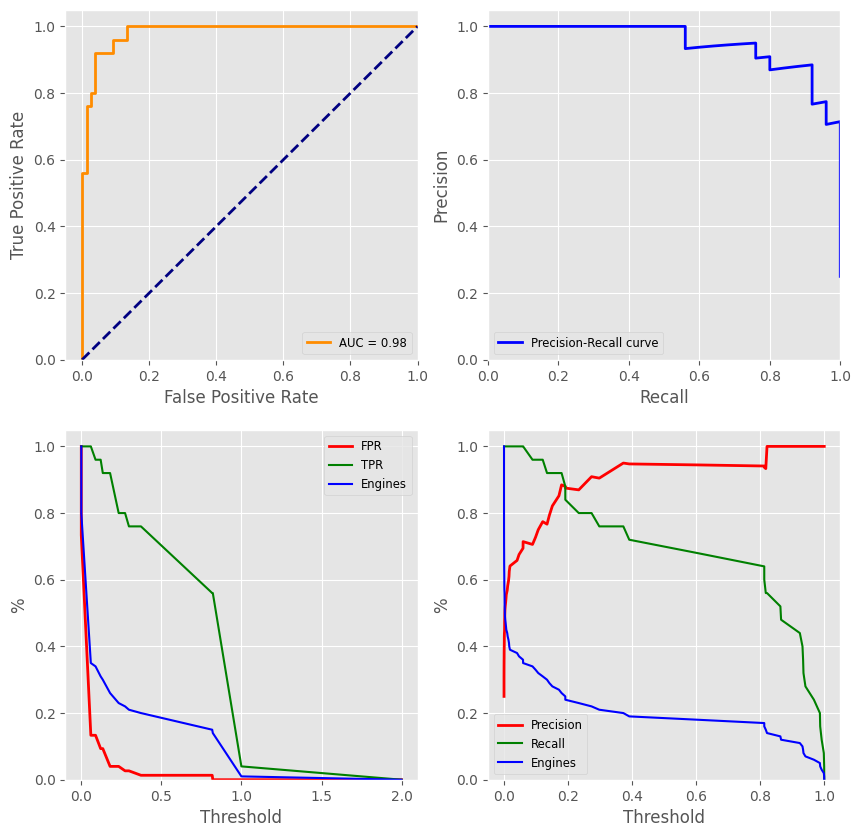

In [14]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfca, pred_rfca = bin_classify(model, clf_rfca, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, roc_rfca, prc_rfca = bin_class_metrics(model, y_test, pred_rfca.y_pred, pred_rfca.y_score, print_out=True, plot_out=True)

In [15]:
metrics_rfc = pd.concat([metrics_rfcb, metrics_rfca], axis=1)
metrics_rfc

,Random Forest B,Random Forest A
Accuracy,0.910000,0.910000
Precision,0.944444,0.944444
Recall,0.680000,0.680000
F1 Score,0.790698,0.790698
ROC AUC,0.980267,0.982400


#Comparing all Binary Classification algorithms tested

In [16]:
#compare all models
metrics_bn = pd.concat([metrics_lgr, metrics_dtr, metrics_rfc], axis=1)
metrics_bn

,Logistic Regression B,Logistic Regression A,Decision Tree B,Decision Tree A,Random Forest B,Random Forest A
Accuracy,0.910000,0.920000,0.880000,0.920000,0.910000,0.910000
Precision,0.944444,1.000000,0.933333,0.947368,0.944444,0.944444
Recall,0.680000,0.680000,0.560000,0.720000,0.680000,0.680000
F1 Score,0.790698,0.809524,0.700000,0.818182,0.790698,0.790698
ROC AUC,0.982933,0.981867,0.945067,0.962933,0.980267,0.982400


Random Forests scored best AUC ROC. It also noticed that feature extraction has improved most models performance metrics.  

Let us compare the AUC ROC and Precision-Recall curves as well

Text(0.5, 1.0, 'Precision Recall Curve')

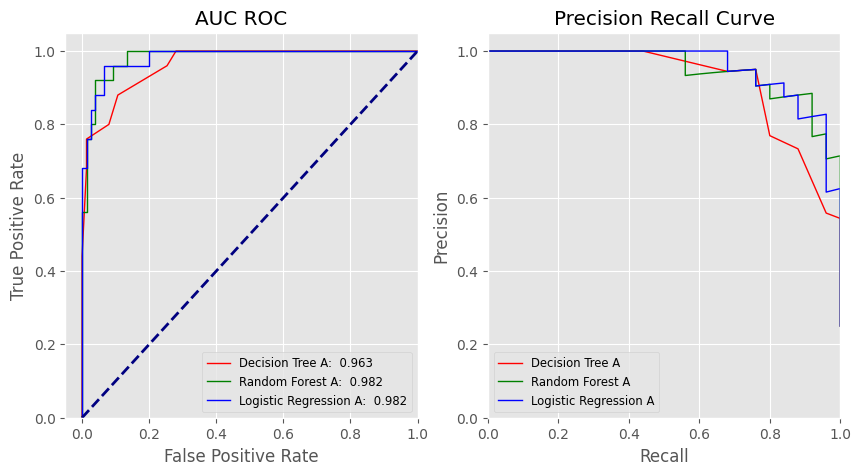

In [17]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)

ax1.plot(roc_dtra.FPR, roc_dtra.TPR, color='red', lw=1, label= metrics_dtra.columns.values.tolist()[0] + ':  %.3f' % metrics_dtra.at['ROC AUC', metrics_dtra.columns.values.tolist()[0]])
ax1.plot(roc_rfca.FPR, roc_rfca.TPR, color='green', lw=1, label= metrics_rfca.columns.values.tolist()[0] + ':  %.3f' % metrics_rfca.at['ROC AUC', metrics_rfca.columns.values.tolist()[0]])
ax1.plot(roc_lgra.FPR, roc_lgra.TPR, color='blue', lw=1, label= metrics_lgra.columns.values.tolist()[0] + ':  %.3f' % metrics_lgra.at['ROC AUC', metrics_lgra.columns.values.tolist()[0]])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('AUC ROC')

ax2.plot(prc_dtra.Recall, prc_dtra.Precision, color='red', lw=1, label= metrics_dtra.columns.values.tolist()[0])
ax2.plot(prc_rfca.Recall, prc_rfca.Precision, color='green', lw=1, label= metrics_rfca.columns.values.tolist()[0])
ax2.plot(prc_lgra.Recall, prc_lgra.Precision, color='blue', lw=1, label= metrics_lgra.columns.values.tolist()[0])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('Precision Recall Curve')
        

__Binary Classification Summary:__  

* Most of the binary classifiers showed better performance metrics with the addition of new features.  
* Accuracy of Logistic Regression and Decision Tree after feature etraction is higher 92 %
* Random Forest showed same performance before and after feature engineering in terms of ROC AUC, which is 98.02%.  
* With respect to AUC-ROC Random Forest Classifier succeeds as compared to all other models.
* The graphs for TPR, FPR, and Engines are showed



